# スペクトルデータの分析を行う

## ライブラリをインポート

In [2]:
import glob
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)

warnings.filterwarnings("ignore")

## material_projects_maked_xrd_pattern_cubicに格納されているファイルを確認

In [3]:
files_cubic = glob.glob("../input/material_projects_maked_xrd_pattern_cubic/*.csv")
len(files_cubic)

4575

In [4]:
# データフレームのリストを作成
df_cubic = [pd.read_csv(file_path) for file_path in files_cubic]

In [5]:
# df_cubicの1つ目を表示
df_cubic[0]

,2theta,Intensity
0,5.00,0.003950
1,5.01,0.003953
2,5.02,0.003956
3,5.03,0.003959
4,5.04,0.003962
...,...,...
9495,99.95,0.003178
9496,99.96,0.003175
9497,99.97,0.003172
9498,99.98,0.003169


## material_projects_maked_xrd_pattern_not_cubicに格納されているファイルを確認

In [6]:
# ファイルのリストを取得
files_not_cubic = glob.glob(
    "../input/material_projects_maked_xrd_pattern_not_cubic/*.csv"
)
len(files_not_cubic)

5425

In [7]:
# データフレームのリストを作成
df_not_cubic = [pd.read_csv(file_path) for file_path in files_not_cubic]

In [8]:
# df_not_cubicの1つ目を表示
df_not_cubic[0]

,2theta,Intensity
0,5.00,0.015479
1,5.01,0.015492
2,5.02,0.015505
3,5.03,0.015518
4,5.04,0.015531
...,...,...
9495,99.95,0.009290
9496,99.96,0.009283
9497,99.97,0.009275
9498,99.98,0.009268


## cubic構造のデータとnon-cubic構造のデータとで共通の2θ範囲を設定

In [9]:
# 同じ2theta範囲を取得
theta_min = max(
    max(df["2theta"].min() for df in df_cubic),
    max(df["2theta"].min() for df in df_not_cubic),
)
theta_max = min(
    min(df["2theta"].max() for df in df_cubic),
    min(df["2theta"].max() for df in df_not_cubic),
)
common_2theta = np.arange(theta_min, theta_max + 0.01, 0.01)

In [10]:
# common_2thetaを表示
print(common_2theta)

[ 5.    5.01  5.02 ... 99.97 99.98 99.99]


In [11]:
# 両方のデータを共通の2theta範囲に内挿
interpolated_data_cubic = []
for df in df_cubic:
    interpolated_intensity = np.interp(common_2theta, df["2theta"], df["Intensity"])
    interpolated_data_cubic.append(interpolated_intensity)

interpolated_data_not_cubic = []
for df in df_not_cubic:
    interpolated_intensity = np.interp(common_2theta, df["2theta"], df["Intensity"])
    interpolated_data_not_cubic.append(interpolated_intensity)

# データを1つの行列に統合
data_matrix_cubic = np.array(interpolated_data_cubic)
data_matrix_not_cubic = np.array(interpolated_data_not_cubic)

## cubic構造のデータとnon-cubic構造のデータとを連結させてPCAを実行

In [12]:
# 両方のデータを連結
combined_data_matrix = np.vstack([data_matrix_cubic, data_matrix_not_cubic])

# PCAを実行
pca = PCA(n_components=2)
pca_result_combined = pca.fit_transform(combined_data_matrix)

# 分割してデータフレームに戻す
pca_result_cubic = pca_result_combined[: len(data_matrix_cubic)]
pca_result_not_cubic = pca_result_combined[len(data_matrix_cubic) :]

pca_df_cubic = pd.DataFrame(pca_result_cubic, columns=["PC1", "PC2"])
pca_df_not_cubic = pd.DataFrame(pca_result_not_cubic, columns=["PC1", "PC2"])

In [13]:
pca_df_cubic

,PC1,PC2
0,-512.796467,16.193906
1,-473.345166,-25.704070
2,-336.490319,614.400906
3,-488.834451,197.831042
4,-626.725926,43.373456
...,...,...
4570,-668.876766,73.881768
4571,-665.914687,87.926979
4572,-673.415993,56.590316
4573,-587.628063,53.369280


In [14]:
pca_df_not_cubic

,PC1,PC2
0,-116.267050,-121.827760
1,-586.067984,45.688609
2,-575.927510,-10.008211
3,1538.387360,-1067.299223
4,2098.789429,317.538697
...,...,...
5420,-339.245191,697.190989
5421,-742.996990,125.345948
5422,-334.064328,13.154626
5423,-433.697474,-106.289522


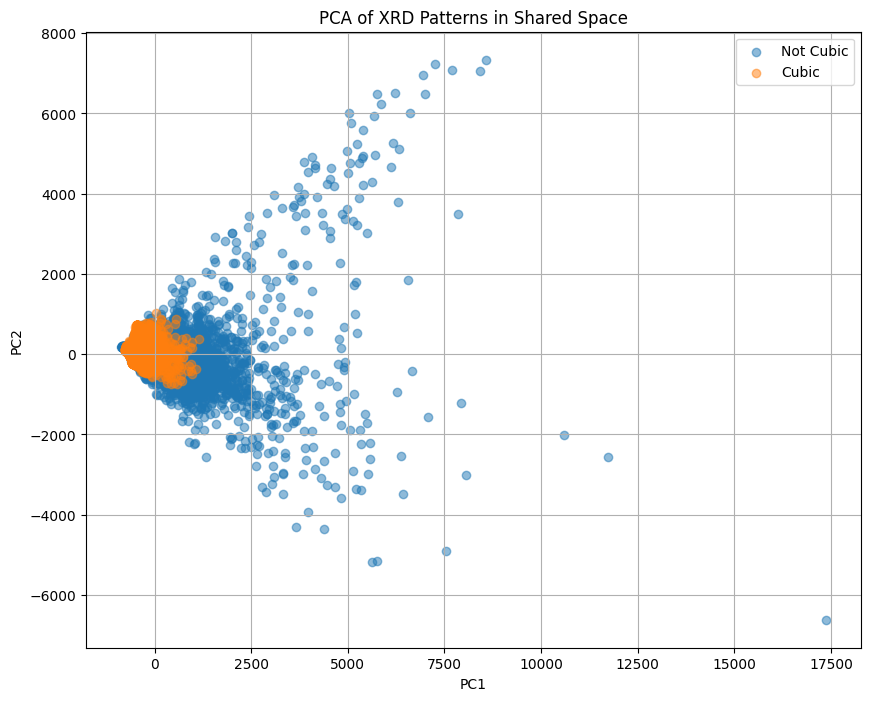

In [15]:
plt.figure(figsize=(10, 8))

plt.scatter(
    pca_df_not_cubic["PC1"],
    pca_df_not_cubic["PC2"],
    alpha=0.5,
    label="Not Cubic",
)

plt.scatter(
    pca_df_cubic["PC1"],
    pca_df_cubic["PC2"],
    alpha=0.5,
    label="Cubic",
)

plt.legend()
plt.title("PCA of XRD Patterns in Shared Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

## cubic構造のデータとnon-cubic構造のデータの分類タスクを行う

In [16]:
params = {
    "objective": "binary",
    "learning_rate": 0.01,
    "reg_alpha": 0.1,
    "reg_lambda": 0.1,
    "random_state": 42,
    "max_depth": 5,
    "n_estimators": 1000,
    "colsample_bytree": 0.7,
    "is_unbalance": True,
}

In [17]:
# pca_dfをPositive、pca_df_をNegativeとしてラベルを付与
pca_df_cubic["Label"] = "Positive"
pca_df_not_cubic["Label"] = "Negative"

# PositiveとNegativeのデータを結合
pca_df_all = pd.concat([pca_df_cubic, pca_df_not_cubic], ignore_index=True)

# train_test_split関数をインポート
from sklearn.model_selection import train_test_split

# データを説明変数と目的変数に分割
X = pca_df_all[["PC1", "PC2"]]
y = pca_df_all["Label"]

# データを学習用とテスト用に分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBMClassifierをインポート
import lightgbm as lgbm

# モデルを作成
model = lgbm.LGBMClassifier(**params, verbose=-1)  # ログ出力を抑制

# モデルを学習
model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="rmse",
    callbacks=[lgbm.early_stopping(stopping_rounds=10)],
)

# テストデータで予測
y_pred = model.predict(X_test)

# accuracy_score関数をインポート
from sklearn.metrics import accuracy_score

# 正解率を計算
accuracy = accuracy_score(y_test, y_pred)

# 正解率を表示
print(f"正解率: {accuracy:.2f}")

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[779]	valid_0's rmse: 0.39618	valid_0's binary_logloss: 0.474793
正解率: 0.77


In [18]:
# F1スコア、適合率、再現率を計算
f1 = f1_score(y_test, y_pred, pos_label="Positive")
precision = precision_score(y_test, y_pred, pos_label="Positive")
recall = recall_score(y_test, y_pred, pos_label="Positive")

# F1スコア、適合率、再現率を表示
print(f"F1スコア: {f1:.2f}")
print(f"適合率: {precision:.2f}")
print(f"再現率: {recall:.2f}")

F1スコア: 0.77
適合率: 0.70
再現率: 0.85


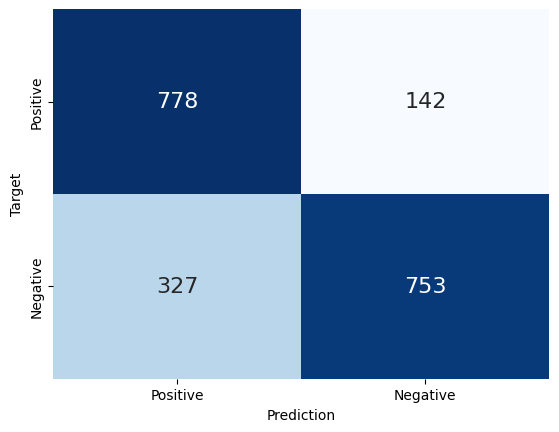

In [19]:
# 混同行列を計算
cm = confusion_matrix(y_test, y_pred)

# 混同行列をmatplotlibでプロット
import seaborn as sns

# confusion matrixを左上がTrue Positive、右上がFalse Positive、左下がFalse Negative、右下がTrue Negativeになるように可視化
sns.heatmap(
    cm[::-1, ::-1],
    annot=True,
    cmap="Blues",
    fmt="d",
    cbar=False,
    annot_kws={"size": 16},
)
plt.xlabel("Prediction")
plt.ylabel("Target")
plt.xticks([0.5, 1.5], ["Positive", "Negative"])
plt.yticks([0.5, 1.5], ["Positive", "Negative"])
plt.show()

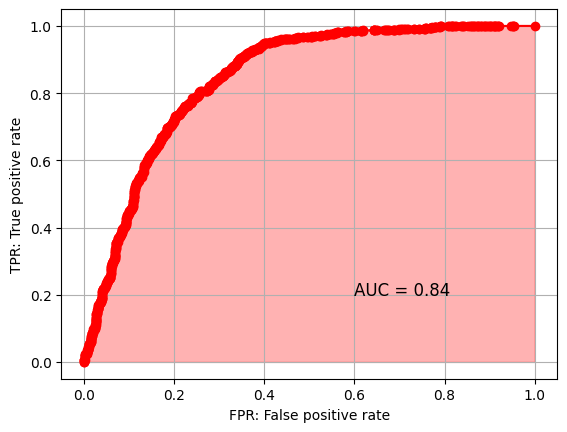

In [20]:
# テストデータで予測
y_pred_proba = model.predict_proba(X_test)[:, 1]

# ROC曲線を計算
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label="Positive")

# AUCを計算
auc = roc_auc_score(y_test, y_pred_proba)

# ROC曲線を表示
plt.plot(fpr, tpr, marker="o", color="r")
plt.fill_between(fpr, tpr, color="r", alpha=0.3)
plt.xlabel("FPR: False positive rate")
plt.ylabel("TPR: True positive rate")
plt.grid()
plt.text(0.6, 0.2, f"AUC = {auc:.2f}", fontsize=12)
plt.show()